In [1]:
from transformers import BertTokenizer, BertModel,BertConfig
import torch
from torch.utils.data import DataLoader,Dataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from tqdm import tqdm
from torch.nn import CrossEntropyLoss,MSELoss

In [2]:
import pandas as pd
import numpy as np
import random
import os

In [3]:
def set_seed(seed = 91):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    return seed

seed = set_seed()

In [15]:
#df = pd.read_csv('../Data/bq_corpus/bq_corpus/train.tsv',delimiter='\t')

In [16]:
!pwd

/home/bool_tbb/jupyter_notebook/CPT_SS/百度文本相似度/Code


In [4]:
def read_tsv(input_file):
    with open(input_file,"r",encoding="utf-8") as file:
        lines = []
        for line in file:
            if len(line.strip().split("\t")) >1:
                lines.append(line.strip().split("\t"))
        df = pd.DataFrame(lines)
    return df

def traversal(rootdir):
    train = pd.DataFrame()
    dev = pd.DataFrame()
    test = pd.DataFrame()
    for parent, dirnames, filenames in os.walk(rootdir):
        for filename in filenames:
            filenameFull = os.path.join(parent, filename)
            if filenameFull.endswith('tsv'):
                df = read_tsv(filenameFull)
                if filename.startswith("train.tsv"):
                    train = pd.concat([train,df],axis = 0)
                elif filename.startswith("dev.tsv"):
                    dev = pd.concat([dev,df],axis = 0)
                elif filename.startswith("test.tsv"):
                     test = pd.concat([test,df],axis = 0)
    cols_dict=['sentence_a', 'sentence_b', 'similarity']
    train.columns = cols_dict
    dev.columns = cols_dict
    test.columns = cols_dict[:2]
    train['similarity'] = train['similarity'].astype(int)
    dev['similarity'] = dev['similarity'].astype(int)
    return train,dev,test

In [5]:
train,dev,test=traversal("../Data/")

In [7]:
train=train.reset_index(drop=True)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 387895 entries, 0 to 387894
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   sentence_a  387895 non-null  object
 1   sentence_b  387895 non-null  object
 2   similarity  387895 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.9+ MB


In [12]:
train.tail()

,sentence_a,sentence_b,similarity
387890,``我们的学校是精神和精神，热爱（时间路径）是我们的第一承诺''。,``我们的学校属于时间和精神，对Rehit的爱（精神之路）是我们的第一承诺。 “”,0
387891,她于6月24日在科克，并于7月8日抵达。,她于6月24日在科克，并于7月8日抵达唐斯。,1
387892,Cornelia Stuyvesant Vanderbilt（George和Edith Va...,John John F. A. Cecil（George和Cornelia Stuyvesa...,0
387893,第三季于2010年6月7日首播，第四季是混合情侣竞赛系统。,第四季于2010年6月7日首播。就像第三季一样，比赛系统是混合情侣。,0
387894,它也位于洛杉矶县大陆海岸的葡萄牙弯曲自然保护区，被称为加州帕洛斯佛得角半岛。,它也位于加利福尼亚大陆海岸的一个位置，位于洛杉矶县帕洛斯弗迪斯半岛的葡萄牙本德自然保护区。,0


In [11]:
train.similarity.value_counts()

1    210258
0    177637
Name: similarity, dtype: int64

In [9]:
train=train.sample(frac=1).reset_index(drop=True)

In [11]:
train

,sentence_a,sentence_b,similarity
0,Ferintosh是卡姆罗斯市中心的一个村庄，位于加拿大艾伯塔省南部和埃德蒙顿东南部。,Ferintosh是加拿大阿尔伯塔省中部的一个村庄，位于加拿大卡姆罗斯以南和埃德蒙顿东南部。,0
1,这车是兰博基尼什么型号,这款兰博基尼是什么型号的,1
2,为什么不能主动分期还款。,为何每次都是提前还款，还不能提升额度？,0
3,Pennypacker出生于纽约南安普敦，在二十世纪之后不久搬到宾夕法尼亚州，然后搬到长岛的...,Pennypacker出生于纽约南安普敦，20世纪初转移到宾夕法尼亚州，然后搬到长岛的纽约市。,1
4,您好，请问招商银行日提现限额是多少？,转出额度,1
...,...,...,...
387890,2017年亚洲室内和武术比赛的电子运动是一项示范运动。,对于2017年亚洲电子和武术比赛室内 - 运动是一项示范运动。,0
387891,龟头如何降低敏感度,怎样降低龟头敏感度啊？,1
387892,小年夜是什么时候,小年夜，大家在做什么？,0
387893,一个女孩问我?我的心里她该怎么走是什么意思,她心里想的是什么意思，她似乎想对我说什么，,0


In [10]:
df_train = train.iloc[2000:,:].reset_index(drop = True)
df_val = train.iloc[:2000,:].reset_index(drop = True)
df_train

,sentence_a,sentence_b,similarity
0,守护甜心第四季网址,守护甜心第四季漫画版,0
1,“魔鬼的青春”（英文：The Devil's Youth）是一部1921年意大利无声电影，由...,魔鬼的年轻人（意大利人：魔鬼的青年）是一部意大利无声电影，由弗朗西斯卡·贝尔蒂尼和罗伯托·罗...,1
2,淘宝年度对账单怎么看,淘宝怎么看年度账单,1
3,2次电话没接到,一直没有接到审核电话,1
4,2001年的马克华纳和2004年的约翰克里劳顿和威廉王子都失去了县。,2001年的约翰克里和2004年的马克华纳都失去了劳登和威廉王子县。,0
...,...,...,...
385890,这个不影响到账的,这个是不有影响的,1
385891,这个QQ表情的人物叫什么？,这个QQ表情人物叫什么？,1
385892,一路向西哪里有的看,一路向西讲什么的，哪里能看,1
385893,找一部美国科幻电影,求一部美国科幻电影,1


In [14]:
df_train

,sentence_a,sentence_b,similarity
0,无语是什么意思啊,无语什么意思,1
1,1960年1月1日，Highveld军团在米德尔堡成立，后者还在内尔斯普雷特镇驻扎了一个后方总部。,军团Highveld于1960年1月1日在米德尔堡成立，它还在内尔斯普雷特镇驻扎了一个后方总部。,1
2,还有像我的世界一样的游戏吗？,我的世界游戏中的蛋有什么用,0
3,极品钢琴中是怎么成为情侣的？,怎么在安卓极品钢琴里面添加歌曲?,0
4,电话已更换了,如何更改接收验证码手机号,1
...,...,...,...
385890,2017年亚洲室内和武术比赛的电子运动是一项示范运动。,对于2017年亚洲电子和武术比赛室内 - 运动是一项示范运动。,0
385891,龟头如何降低敏感度,怎样降低龟头敏感度啊？,1
385892,小年夜是什么时候,小年夜，大家在做什么？,0
385893,一个女孩问我?我的心里她该怎么走是什么意思,她心里想的是什么意思，她似乎想对我说什么，,0


In [11]:
def read_data(dataframe):
    lst = []
    for index, row in dataframe.iterrows():
        s0 = row['sentence_a']
        s1 = row['sentence_b']
        sim = row['similarity']
        lst.append((s0,s1,sim))
    return lst

In [12]:
lst_train = read_data(df_train)
lst_val = read_data(df_val)
lst_test = read_data(dev)

In [27]:
lst_test[0]

('不要借了我是试试看能否操作的', '借款审核期间能否取消借款', 0)

In [30]:
test

,sentence_a,sentence_b
0,为什么我无法看到额度,为什么开通了却没有额度
1,为啥换不了,为两次还都提示失败呢
2,借了钱，但还没有通过，可以取消吗？,可否取消
3,为什么我申请额度输入密码就一直是那个页面,为什么要输入支付密码来验证
4,今天借明天还款可以？,今天借明天还要手续费吗
...,...,...
1995,《土地贝西之地》是贝西伯爵及其 1964 年管弦乐队的录音室专辑，该专辑的音乐由比利·拜尔斯...,《土地贝西之地》是比利·拜尔斯及其管弦乐队在 1964 年录制的录音室专辑，由贝西伯爵作曲和编曲。
1996,他们的任务是保护各种太空前哨不受敌舰群的攻击。,他们的使命是保护各个前哨免受敌人舰队的攻击。
1997,他的母亲伊丽莎白这边有康沃尔公国大法官威廉·莫当特爵士，以及民事诉讼法院首席书记约翰·莫当特。,他的母亲这边有康沃尔公国大法官伊丽莎白·威廉·莫当特爵士，以及民事诉讼法院首席书记约翰·莫当特。
1998,2014 年，该网站推出了用于搜索产品的 iOS 和 Android 应用程序；产品特色包括...,2014 年推出网站 iOS 和安卓应用程序，用于产品搜索，产品功能包括交互式视频 - 产品...


In [13]:
class InputFeature(object):
    def __init__(self,input_ids,position_ids,token_type_ids,
                lm_labels=None,input_len=None):
        
        self.input_ids = input_ids
        self.position_ids = position_ids
        self.token_type_ids = token_type_ids
        self.lm_labels =lm_labels
        if input_len is None:
            self.input_len = len(input_ids)
        else:
            self.input_len = input_len

In [14]:
class BertDataset(Dataset):
    
    def __init__(self,sentence_lst,max_len = 512):
        self.max_len = max_lena
        self.features = BertDataset.build_input_feature(sentence_lst)
    
    def __getitem__(self,i):
        feat_dict = self.features[i]
        if self.max_len is not None and feat_dict['input_len'] > self.max_len:
            feat_dict['input_ids'] = feat_dict['input_dis'][-self.max_len:]
            feat_dict['position_ids'] = feat_dict['position_ids'][-self.max_len:]
            feat_dict['token_type_ids'] = feat_dict['token_type_ids'][-self.max_len:]
        feat = InputFeature(**feat_dict)
        return feat
    
    def __len__(self):
        return len(self.features)
    
    @staticmethod
    def build_input_feature(sentence_lst,begin_text= '[CLS]',sep_text="[SEP]"):
        tokenizer = BertTokenizer.from_pretrained('hfl/chinese-bert-wwm')
        feature = []
        for data in sentence_lst:
            inputs_sentence_0 = data[0]
            inputs_sentence_1 = data[1]
            inputs_0 = tokenizer.encode(begin_text+inputs_sentence_0,add_special_tokens=False)
            inputs_1 = tokenizer.encode(sep_text + inputs_sentence_1,add_special_tokens=False)
            len_inputs_0 = len(inputs_0)
            len_inputs_1 = len(inputs_1)
            inputs = inputs_0 + inputs_1
            len_inputs= len(inputs)
            
            lm_labels = data[2]
            assert len_inputs_0 + len_inputs_1 == len_inputs
            token_type_ids = [0] * len_inputs_0 + [1] * len_inputs_1
            input_ids = inputs
            input_len = len_inputs
            position_ids = list(range(len(input_ids)))
            
            feat_dict = {'input_ids':input_ids,
                        'position_ids':position_ids,
                        'token_type_ids':token_type_ids,
                        'lm_labels':lm_labels,
                        'input_len':input_len}
            feature.append(feat_dict)
        return feature
    
    @staticmethod
    def collate(features):
        inputs_ids = pad_sequence([torch.tensor(f['input_ids'],dtype=torch.long)
                                  for f in features],batch_first=True,padding_value=0)
        
        position_ids = pad_sequence([torch.tensor(f['position_ids'],dtype=torch.long)
                                   for f in features],batch_first=True,padding_value=0)
        
        token_type_ids = pad_sequence([torch.tensor(f['token_type_ids'],dtype=torch.long)
                                      for f in features],batch_first=True,padding_value=0)
        
        labels = torch.tensor([torch.tensor(f['lm_labels'],dtype=torch.long) for f in features])
        
        return (inputs_ids,position_ids,token_type_ids,labels)

In [15]:
dataset_train= BertDataset.build_input_feature(lst_train)
dataset_val= BertDataset.build_input_feature(lst_val)
dataset_test= BertDataset.build_input_feature(lst_test)

In [37]:
loader_train = DataLoader(dataset_train,collate_fn=BertDataset.collate,batch_size=500)
loader_val = DataLoader(dataset_val,collate_fn=BertDataset.collate,batch_size=500)
loader_test = DataLoader(dataset_test,collate_fn=BertDataset.collate,batch_size=500)

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.trans= BertModel.from_pretrained("hfl/chinese-bert-wwm")
        for p in self.parameters():
            p.requires_grad = True
        self.norm = nn.LayerNorm(768)
        self.fc = nn.Linear(768, 50)
        self.tanh = nn.ReLU()
        self.fc2  = nn.Linear(50,2)
        #self.sig = nn.Sigmoid()
    def forward(self, input_ids=None, token_type_ids=None, position_ids=None):
        x = self.trans(input_ids=input_ids, token_type_ids=token_type_ids,position_ids=position_ids)
        x= self.norm(torch.mean(x[0],dim=1,keepdim=True)).squeeze_(1)
        #print(x.size())
        x = self.tanh(self.fc(x))
        x =self.fc2(x)
        return x


net = Net()

In [ ]:
def val_lossF(net, device, criterion, dataloader):
    net.eval()
    mean_loss = 0
    count = 0
    true_labelss = []
    list_val_outputs = []
    val_metric = 0
    
    with torch.no_grad():
        for  i, (token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2,labels) in enumerate(dataloader):
            token_ids1, attn_masks1, token_type_ids1 = token_ids1.to(device), attn_masks1.to(device), token_type_ids1.to(device)
            token_ids2, attn_masks2, token_type_ids2 = token_ids2.to(device), attn_masks2.to(device), token_type_ids2.to(device)
            labels = labels.to(device)
            
            val_output = net(token_ids1, attn_masks1, token_type_ids1,token_ids2, attn_masks2, token_type_ids2)
            mean_loss += criterion(val_output, labels.float()).item()
            count += 1

            val_outputs = val_output.sigmoid().cpu().numpy()
            val_outputs = np.where(val_outputs>thres, 1, 0)
            list_val_outputs += val_outputs.tolist()
            labelss = labels.cpu().numpy()
            true_labelss += labelss.tolist()  

        val_metric = accuracy_score(list_val_outputs,true_labelss)       
    return mean_loss / count, val_metric

In [18]:
loss_lst=[]
def run(model,train_dataloader,learning_rate,epoches):
    model.to("cuda:0")
    ngpu=3
    model = nn.DataParallel(model, [0,1,2])
    #model.to(device)
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()),lr=learning_rate)
    running_loss = 0 
    step = 0
    epoch = 0 
    back=5
    pbar = tqdm(enumerate(train_dataloader),total=len(train_dataloader))
    loss_function  = CrossEntropyLoss(reduction='mean')
    while epoch < epoches:
        bckcount=0
        try:
            with tqdm(enumerate(train_dataloader),total=len(train_dataloader)) as pbar:
                for i,batch in pbar:
                    input_ids,position_ids,token_type_ids,label_ids = batch
                    logits = model(input_ids=input_ids.cuda(),position_ids=position_ids.cuda(),token_type_ids=token_type_ids.cuda())
                    #print(type(input_ids))
                    #(logits.size())
                    #print(label_ids)
                    loss = loss_function(logits.cuda(),label_ids.cuda())
                    #print("UEsss")
                    #break
                    #print(i)
                    if i%100==0:
                        loss_lst.append(loss.detach())
                        #break
                    running_loss += loss.item()
                    pbar.set_description('Train (Epoch{}):{:.4f}'.format(epoch,running_loss/(step+1)))
                    #bckcount+=1
                    #if bckcount>=5:
                    bckcount=0
                    loss.backward()
                    optimizer.step() # w = w +dw
                    optimizer.zero_grad()# dw = 0
                    step += 1
                epoch += 1
        except KeyboardInterrupt:
            pbar.close()
            raise
        pbar.close()
    import time
    localtime = str(time.asctime( time.localtime(time.time()) ))
    with open('al{}.pkl'.format(localtime),'wb') as f:        
        
        torch.save({'model':model.state_dict(),
               'epoch':epoch},f)

In [22]:
for param in net.trans.parameters():
    #print(param.requires_grad)
    param.requires_grad=False
    #break

In [24]:
run(net,loader_train,5e-5,10)

Train (Epoch9):0.6897: 100%|██████████| 772/772 [08:08<00:00,  1.66it/s]


In [26]:
torch.cuda.empty_cache()

In [27]:

import torch
flag = torch.cuda.is_available()
if flag:
    print("CUDA可使用")
else:
    print("CUDA不可用")

ngpu= 1
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print("驱动为：",device)
print("GPU型号： ",torch.cuda.get_device_name(0))


CUDA可使用
驱动为： cuda:0
GPU型号：  GeForce RTX 2080 Ti


In [20]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'cost')

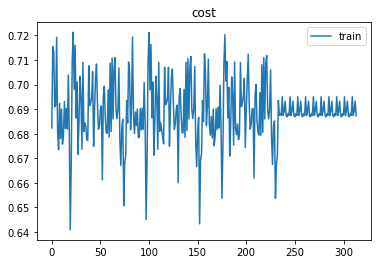

In [25]:
plt.plot(range(len(loss_lst)), loss_lst)
plt.legend(["train"])
plt.title("cost")

In [31]:
test_lst = test.values.tolist()

In [32]:
test_lst[0]

['为什么我无法看到额度', '为什么开通了却没有额度']

In [36]:
print(next(net.parameters()).device)

cuda:0


In [50]:
from sklearn.metrics import accuracy_score

In [51]:
def val_acc(net, device, criterion, dataloader):
    net.eval()
    mean_loss = 0
    count = 0
    true_labelss = []
    list_val_outputs = []
    val_metric = 0
    
    with torch.no_grad(),tqdm(enumerate(loader_test),total=len(loader_test)) as pbar:
        for  i, batch in enumerate(dataloader):
            input_ids,position_ids,token_type_ids,label_ids = batch
            input_ids,position_ids,token_type_ids,label_ids = input_ids.to(device),position_ids.to(device),token_type_ids.to(device),label_ids.to(device)
            labels = label_ids.to(device)
            val_output = net(input_ids=input_ids,position_ids=position_ids,token_type_ids=token_type_ids)
            mean_loss += criterion(val_output, labels).item()
            count += 1
            pred = val_output.topk(1,dim=-1)[1].squeeze_().cpu().tolist()
            list_val_outputs += pred
            labelss = labels.cpu().numpy()
            true_labelss += labelss.tolist()  

        val_metric = accuracy_score(list_val_outputs,true_labelss)       
    return mean_loss / count, val_metric

In [52]:
val_acc(net,'cuda:0',CrossEntropyLoss(reduction='mean'),loader_test)

  0%|          | 0/42 [00:00<?, ?it/s]


(0.7003146665436881, 0.49298144409191424)

In [ ]:
with tqdm(enumerate(loader_test),total=len(loader_test)) as pbar:
    for i,batch in pbar:
        input_ids,position_ids,token_type_ids,label_ids = batch
        logits = model(input_ids=input_ids.cuda(),position_ids=position_ids.cuda(),token_type_ids=token_type_ids.cuda())
        #print(type(input_ids))
        #(logits.size())
        #print(label_ids)
        loss = loss_function(logits.cuda(),label_ids.cuda())
        #print("UEsss")
        #break
        #print(i)
        if i%100==0:
            loss_lst.append(loss.detach())
            #break
        running_loss += loss.item()
        pbar.set_description('Train (Epoch{}):{:.4f}'.format(epoch,running_loss/(step+1)))
        #bckcount+=1
        #if bckcount>=5:
        bckcount=0
        loss.backward()
        optimizer.step() # w = w +dw
        optimizer.zero_grad()# dw = 0
        step += 1


In [ ]:
lst_test=[]
for i,s in tqdm(enumerate(lst_df),total=len(lst_df)):
    sen=s[1]
    #print(sen)
    score= net(torch.tensor(tokenizer.encode(sen)).to(device).unsqueeze_(0)).detach()
    score = score.topk(1)
    #print(score[1].item())
    lst_test.append((i,dic2[score[1].item()]))